<a href="https://colab.research.google.com/github/Nithinps021/Project_IISU/blob/main/Chatbot_retrieval_gru_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pickle5
!pip install nltk

In [83]:
import json
import pickle
import numpy as np
import tensorflow as tf
import random


In [66]:
words = []
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('intents.json').read()
intents = json.loads(data_file)

In [67]:
for intent in intents['intents']:
    for pattern in intent['patterns']:
        # tokenize each word
        # add documents in the corpus
        documents.append((pattern, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [141]:
vocab_size = 90
embedding_dim=10
max_length = 20
trunc_type= 'post'
oov_tok="<OOV>"
total_labels=len(classes)

In [144]:
random.shuffle(documents)
training_sen=[]
training_label=[]
for sentence,label in documents:
  training_sen.append(sentence)
  l=np.zeros(total_labels)
  l[classes.index(label)]=1
  training_label.append(l)

In [145]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sen)

In [146]:
sequences = tokenizer.texts_to_sequences(training_sen)
padded = pad_sequences(sequences, maxlen=max_length, 
                       truncating = trunc_type)

In [158]:

Y = np.array(training_label)
Y.shape

(66, 17)

In [166]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(total_labels, activation='sigmoid')
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 20, 10)            900       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               8448      
 l)                                                              
                                                                 
 dense_25 (Dense)            (None, 30)                1950      
                                                                 
 dense_26 (Dense)            (None, 17)                527       
                                                                 
Total params: 11,825
Trainable params: 11,825
Non-trainable params: 0
_________________________________________________________________


In [167]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
history=model.fit(padded,Y, epochs=200,verbose=1)
model.save('chatbot_model.h5', history)

Epoch 1/200
3/3 [==============================] - 3s 15ms/step - loss: 2.8322 - accuracy: 0.0909
Epoch 2/200
3/3 [==============================] - 0s 13ms/step - loss: 2.8295 - accuracy: 0.1212
Epoch 3/200
3/3 [==============================] - 0s 11ms/step - loss: 2.8280 - accuracy: 0.1061
Epoch 4/200
3/3 [==============================] - 0s 12ms/step - loss: 2.8233 - accuracy: 0.1818
Epoch 5/200
3/3 [==============================] - 0s 11ms/step - loss: 2.8197 - accuracy: 0.1364
Epoch 6/200
3/3 [==============================] - 0s 12ms/step - loss: 2.8177 - accuracy: 0.1364
Epoch 7/200
3/3 [==============================] - 0s 13ms/step - loss: 2.8139 - accuracy: 0.1364
Epoch 8/200
3/3 [==============================] - 0s 13ms/step - loss: 2.8105 - accuracy: 0.1515
Epoch 9/200
3/3 [==============================] - 0s 12ms/step - loss: 2.8079 - accuracy: 0.1364
Epoch 10/200
3/3 [==============================] - 0s 12ms/step - loss: 2.8040 - accuracy: 0.1970
Epoch 11/200
3/3 [=

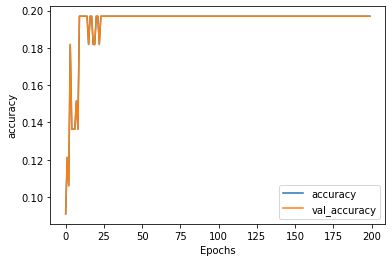

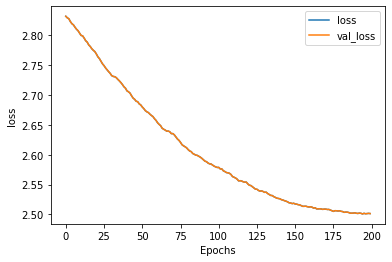

In [168]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [35]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import pickle
import numpy as np

from keras.models import load_model
model = load_model('chatbot_model.h5')
import json
import random
intents = json.loads(open('intents.json').read())
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))


def clean_up_sentence(sentence):
    # tokenize the pattern - split words into array
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word - create short form for word
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence

def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words)  
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))

def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

def chatbot_response(msg):
    ints = predict_class(msg, model)
    res = getResponse(ints, intents)
    return res


#Creating GUI with tkinter
# Prashant_sagar
import tkinter
from tkinter import *


def send():
    msg = EntryBox.get("1.0",'end-1c').strip()
    EntryBox.delete("0.0",END)

    if msg != '':
        ChatLog.config(state=NORMAL)
        ChatLog.insert(END, "You: " + msg + '\n\n')
        ChatLog.config(foreground="#442265", font=("maroon", 12 ))
    
        res = chatbot_response(msg)
        ChatLog.insert(END, "ITM: " + res + '\n\n')
            
        ChatLog.config(state=DISABLED)
        ChatLog.yview(END)
 


In [ ]:
print('Start the chat with bot and enter /stop to stop')
while(True):
  msg=input()
  if msg=='/stop':
    break
  res = chatbot_response(msg)
  print(res)
